#  Regularizing Neural Networks 

* Neural networks learn a set of weights that best map inputs to outputs.
* Deep learning neural networks are likely to quickly overfit a training dataset with few examples.

## Weight penalties

* A network with large network weights can be a sign of an unstable network where small changes in the input can lead to large changes in the output. This can be a sign that the network has overfit the training dataset and will likely perform poorly when making predictions on new data.
* A solution to this problem is to update the learning algorithm to encourage the network to keep the weights small. This is called weight regularization and it can be used as a general technique to reduce overfitting of the training dataset and improve the generalization of the model.
* We will mainly explore L1 regularization and L2 regularization.

### L1 norm and L2 norm

* Before delving into L1/L2 regularization, let's spend a bit of time introducing L1/L2 norm.
* In mathematics, a "norm" is a function from vector space to the non-negative real numbers that behaves in certain ways "like the distance from the origin".
* L1 norm:

$$
\left\lVert x \right\rVert_1 = \sum_{i=1}^n \left| x_i \right|
$$

* L2 norm:

$$
\left\lVert x \right\rVert_2 = \sqrt{\sum_{i=1}^n x_i^2}
$$

* Function graph (one of the interesting differences is how their derivatives change when $w$ changes):

<img src="./assets/regularization/l1-and-l2-norms.gif" alt="L1 and L2 norms" style="width: 500px;"/>

### L1 and L2 regularization

* The formula for MSE with L1 regularization is:

$$
MSE_{L1} = \frac{1}{n} \sum_{i=1}^{n}(y_i - \hat{y}i)^2 + \lambda \sum_{j=1}^{p}(|w_j|)
$$

* where:

    * $n$ is the number of samples in the dataset
    * $y_i$ is the true target value for the $i$-th sample
    * $\hat{y}_i$ is the predicted target value for the $i$-th sample
    * $p$ is the number of weights in the dataset
    * $w_j$ is the coefficient of the $j$-th weight in the model
    * $\lambda$ is the regularization parameter, which controls the strength of the L1 regularization penalty

* The general idea is that apart from minimizing the loss function, we also want to penalize the L1 "distance" from the weight vector to origin. Note that we regularize weights of a neuron only and biases are not regularized.
  * The reason of the exclusion of biases is that overfitting usually requires the output of the model to be sensitive to small changes in the input data (i.e. to exactly interpolate the target values, you tend to need a lot of curvature in the fitted function). The bias parameters don't contribute to the curvature of the model, so there is usually little point in regularizing them as well. 

* Similarly, we have the formula for L2 regularization:

$$
MSE_{L2} = \frac{1}{n} \sum_{i=1}^{n}(y_i - \hat{y_i})^2 + \lambda \sum_{j=1}^{p}(w_j^2)
$$

### L1/L2 comparison

* L1 regularization can also be seen as a feature selection method because some weights will be actually zero, making the model a sparse one.
* L2 shrinks weights to be small, but not making them exactly 0.

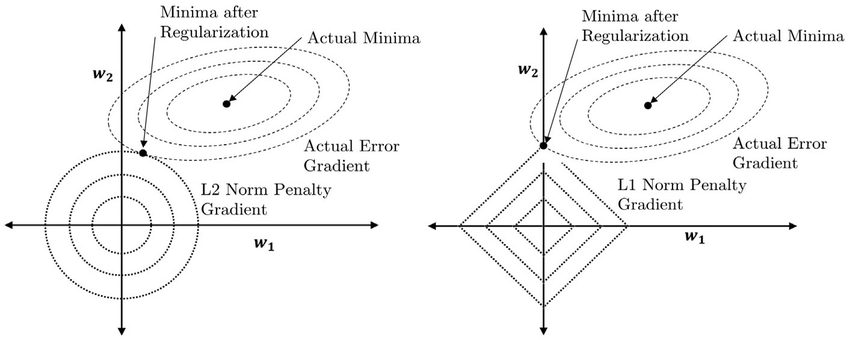

### Toy project

* Let's have a toy project that demonstrates this!
  * It seems that neural network is less prone to overfitting than traditional models such as Random Forest, but given the nature of this note, let's use neural network anyways...
 
#### Prepare data

2023-05-29 15:10:23.104824: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-29 15:10:23.147127: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-29 15:10:23.148297: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-29 15:10:23.932255: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


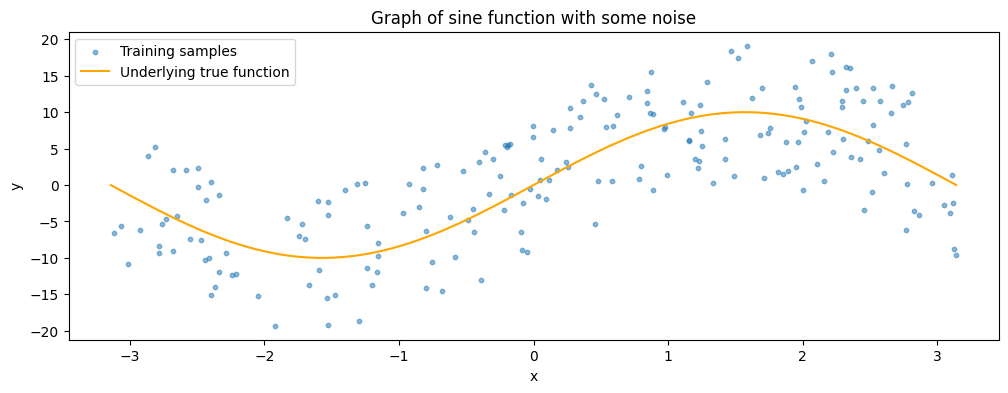

In [1]:
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

# So that we can reproduce the same result
random.seed(1080)
np.random.seed(1024)
tf.random.set_seed(168)

amplitude = 10.0
X = np.random.uniform(-np.pi, np.pi, size=(400, 1))
y = np.sin(X) * amplitude
y_noise = np.random.uniform(low=-amplitude,high=amplitude, size=y.shape)
y += y_noise
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=8)

# Generate a grid of x values for plotting the true function
x_plot = np.linspace(-np.pi, np.pi, num=100)
y_plot = np.sin(x_plot) * amplitude


plt.figure(figsize=(12, 4))
plt.scatter(x_train, y_train, s=10, alpha=0.5, label="Training samples")
plt.plot(x_plot, y_plot, color='orange', label='Underlying true function')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Graph of sine function with some noise')
plt.legend()
plt.show()

#### Train the model

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

def lr_scheduler(epoch: int, lr: float) -> float:
    if epoch < 20:
        return lr
    else:
        return lr * 0.95

neuron_count = 1024
model = keras.Sequential([
    layers.Dense(neuron_count, activation='relu'),
    layers.Dense(neuron_count, activation='relu'),
    layers.Dense(neuron_count, activation='relu'),
    layers.Dense(neuron_count, activation='relu'),
    layers.Dense(neuron_count, activation='relu'),
    layers.Dense(1)
])

λ_l1 = 5e-5
model_l1 = keras.Sequential([
    layers.Dense(neuron_count, activation='relu', kernel_regularizer=keras.regularizers.l1(λ_l1)),
    layers.Dense(neuron_count, activation='relu', kernel_regularizer=keras.regularizers.l1(λ_l1)),
    layers.Dense(neuron_count, activation='relu', kernel_regularizer=keras.regularizers.l1(λ_l1)),
    layers.Dense(neuron_count, activation='relu', kernel_regularizer=keras.regularizers.l1(λ_l1)),
    layers.Dense(neuron_count, activation='relu', kernel_regularizer=keras.regularizers.l1(λ_l1)),
    layers.Dense(1)
])
λ_l2 = 3e-3
model_l2 = keras.Sequential([
    layers.Dense(neuron_count, activation='relu', kernel_regularizer=keras.regularizers.l2(λ_l2)),
    layers.Dense(neuron_count, activation='relu', kernel_regularizer=keras.regularizers.l2(λ_l2)),
    layers.Dense(neuron_count, activation='relu', kernel_regularizer=keras.regularizers.l2(λ_l2)),
    layers.Dense(neuron_count, activation='relu', kernel_regularizer=keras.regularizers.l2(λ_l2)),
    layers.Dense(neuron_count, activation='relu', kernel_regularizer=keras.regularizers.l2(λ_l2)),
    layers.Dense(1)
])

loss_fn = keras.losses.MeanSquaredError()

lr = 5e-2
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=loss_fn, metrics=['mse'])
model_l1.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=loss_fn, metrics=['mse'])
model_l2.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=loss_fn, metrics=['mse'])

epochs = 100
model.fit(x_train, y_train, epochs=epochs, callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler)], verbose=0)
model_l1.fit(x_train, y_train, epochs=epochs, callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler)], verbose=0)
model_l2.fit(x_train, y_train, epochs=epochs, callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler)], verbose=0)

#### Evaluate model performance

* For **training** data, the MSE of L1/L2-regularized models is higher.
* For **testing** data, the MSE of L1/L2-regularized models is lower.

7/7 [==============================] - 0s 7ms/step
tf.Tensor(5.0276036, shape=(), dtype=float32)
7/7 [==============================] - 0s 6ms/step
tf.Tensor(18.550224, shape=(), dtype=float32)
7/7 [==============================] - 0s 19ms/step
tf.Tensor(26.203188, shape=(), dtype=float32)


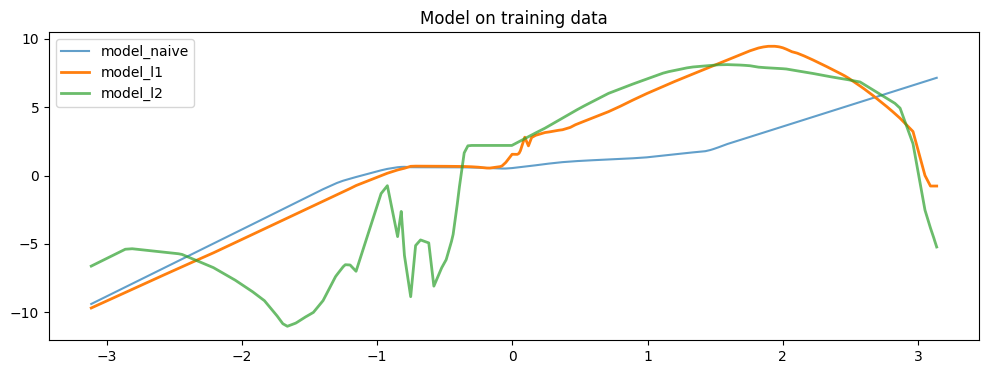

In [3]:
mse = keras.losses.MeanSquaredError()

plt.figure(figsize=(12, 4))

x_sorted, y_sorted = zip(*sorted(zip(x_train, model.predict(x_train))))
plt.plot(x_sorted, y_sorted, alpha=0.7, label='model_naive')
print(mse(x_sorted, y_sorted))

x_sorted, y_sorted = zip(*sorted(zip(x_train, model_l1.predict(x_train))))
plt.plot(x_sorted, y_sorted, linewidth=2, label='model_l1')
print(mse(x_sorted, y_sorted))

x_sorted, y_sorted = zip(*sorted(zip(x_train, model_l2.predict(x_train))))
plt.plot(x_sorted, y_sorted, linewidth=2, alpha=0.7, label='model_l2')
print(mse(x_sorted, y_sorted))


plt.title('Model on training data')
plt.legend()
plt.show()

7/7 [==============================] - 0s 5ms/step


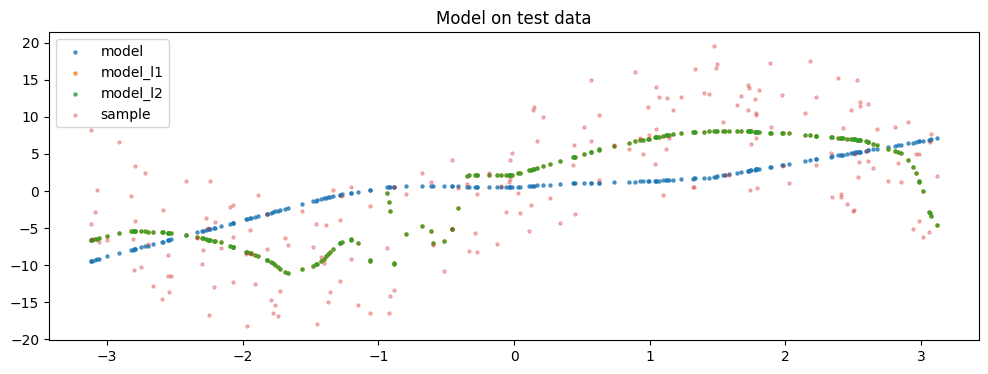

tf.Tensor(59.32042, shape=(), dtype=float32)
tf.Tensor(43.91935, shape=(), dtype=float32)
tf.Tensor(34.63639, shape=(), dtype=float32)


In [4]:
y_pred = model.predict(x_test)
y_pred_l1 = model_l1.predict(x_test)
y_pred_l2 = model_l2.predict(x_test)

plt.figure(figsize=(12, 4))
plt.scatter(x_test[:, 0], y_pred,    s=5, alpha=0.7, label='model')
plt.scatter(x_test[:, 0], y_pred_l2, s=5, alpha=0.7, label='model_l1')
plt.scatter(x_test[:, 0], y_pred_l2, s=5, alpha=0.7, label='model_l2')
plt.scatter(x_test[:, 0], y_test, s=5, alpha=0.3, label='sample')
plt.title('Model on test data')
plt.legend()
plt.show()

print(mse(y_test, y_pred))
print(mse(y_test, y_pred_l1))
print(mse(y_test, y_pred_l2))

#### Calculate L1 and L2 norm of models

* Results show that regularized models do have smaller L1/L2 norms.

In [5]:
def get_l1_and_l2_norms(model):

    for i in range(len(model.layers)):
        # layer.get_weights()[0]: weights
        # layer.get_weights()[1]: biases
        print(f'{np.linalg.norm(model.layers[i].get_weights()[0].flatten(), ord=1):8.1f}', end=', ')
        print(f'{np.linalg.norm(model.layers[i].get_weights()[0].flatten(), ord=2):8.1f}')
    print()

print(f'L1 norm    L2 norm')
print('model: ')
get_l1_and_l2_norms(model)
print('model_l1: ')
get_l1_and_l2_norms(model_l1)
print('model_l2: ')
get_l1_and_l2_norms(model_l2)

L1 norm    L2 norm
model: 
   195.5,      6.5
220699.8,    246.4
195104.3,    229.5
194138.1,    229.1
204380.7,    235.9
   160.3,      5.7

model_l1: 
   169.4,      5.6
186693.5,    232.1
156485.8,    206.8
161883.6,    213.3
179677.8,    225.3
   173.4,      6.2

model_l2: 
   139.0,      4.9
199513.6,    235.7
152824.6,    205.0
155977.6,    208.3
199036.4,    245.5
   221.2,      7.5



## Dropout

* Ensembles of neural networks (i.e., a large number of neural networks) with different model configurations are known to reduce overfitting, but require the additional computational expense of training and maintaining multiple models.
* A single model can be used to simulate having a large number of different network architectures by randomly dropping out nodes during **training**.
* Dropout is implemented per-layer in a neural network. It can be used with most types of layers, such as dense fully connected layers, convolutional layers, and recurrent layers such as the long short-term memory network layer.
* Dropout can be used after convolutional layers (e.g. Conv2D) and after pooling layers (e.g. MaxPooling2D).

### Toy project

* There doesn't seem to be a straightforward way to examine the internal dropout state of a model during training. We may first take a look at the dropout layer's behavior separately.
  * Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

In [6]:
do_layer = tf.keras.layers.Dropout(rate=.2, input_shape=(2,))

data = np.arange(10).reshape(5, 2).astype(np.float32)
print(data)
outputs = do_layer(data, training=True)
print(outputs)

[[0. 1.]
 [2. 3.]
 [4. 5.]
 [6. 7.]
 [8. 9.]]
tf.Tensor(
[[ 0.    1.25]
 [ 2.5   3.75]
 [ 0.    0.  ]
 [ 0.    8.75]
 [10.   11.25]], shape=(5, 2), dtype=float32)


In [7]:
rate = 0.1
model_dropout = keras.Sequential([
    layers.Dense(neuron_count, activation='relu'),
    layers.Dropout(rate),
    layers.Dense(neuron_count, activation='relu'),
    layers.Dropout(rate),
    layers.Dense(neuron_count, activation='relu'),
    layers.Dropout(rate),
    layers.Dense(neuron_count, activation='relu'),
    layers.Dropout(rate),
    layers.Dense(neuron_count, activation='relu'),
    layers.Dense(1)
])

model_dropout.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=loss_fn, metrics=['mse'])
model_dropout.fit(x_train, y_train, epochs=epochs, callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_scheduler)], verbose=0)

#### Evaluate model performance

* The result is more difficult to interpret this time as dropout makes both training and testing better.

7/7 [==============================] - 0s 7ms/step


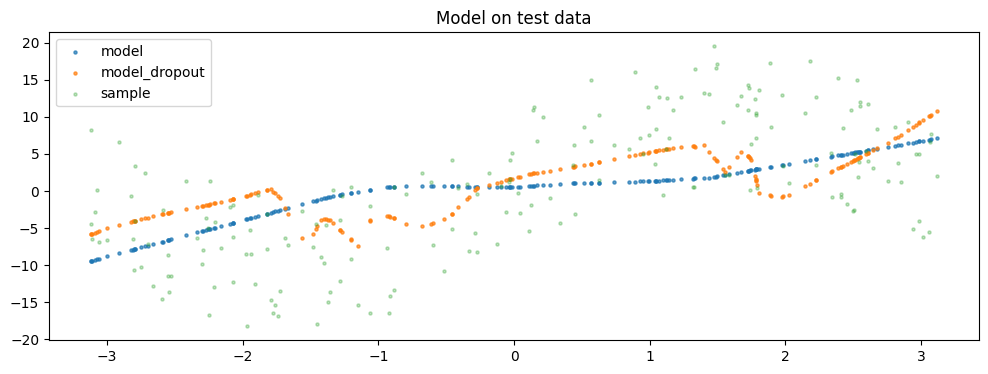

7/7 [==============================] - 0s 6ms/step
tf.Tensor(57.080128, shape=(), dtype=float32)
7/7 [==============================] - 0s 7ms/step
tf.Tensor(53.850533, shape=(), dtype=float32)
tf.Tensor(59.32042, shape=(), dtype=float32)
tf.Tensor(55.473656, shape=(), dtype=float32)


In [8]:
y_pred_dropout = model_dropout.predict(x_test)

plt.figure(figsize=(12, 4))
plt.scatter(x_test, y_pred,         s=5, alpha=0.7, label='model')
plt.scatter(x_test, y_pred_dropout, s=5, alpha=0.7, label='model_dropout')
plt.scatter(x_test, y_test,         s=5, alpha=0.3, label='sample')
plt.title('Model on test data')
plt.legend()
plt.show()

print(mse(y_train, model.predict(x_train)))
print(mse(y_train, model_dropout.predict(x_train)))
print(mse(y_test, y_pred))
print(mse(y_test, y_pred_dropout))

## Augmentation

- Data augmentation is a technique that, for some applications, allows machine learning practitioners to get more data almost for free.

  - In computer vision, data augmentation provides larger training set by flipping, zooming, and translating the original images.

- The idea of augmentation is that we want to increase the diversity of the data, hoping that it can help reducing variance.


## References
* [Use Weight Regularization to Reduce Overfitting of Deep Learning Models](https://machinelearningmastery.com/weight-regularization-to-reduce-overfitting-of-deep-learning-models/)
* [A Gentle Introduction to Dropout for Regularizing Deep Neural Networks](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/)
* [How to Reduce Overfitting With Dropout Regularization in Keras](https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/)
* [How to Reduce Overfitting Using Weight Constraints in Keras](https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-neural-networks-with-weight-constraints-in-keras/)